In [34]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from glob import glob
import yaml
import numpy as np
from patoolib import extract_archive
import importlib

import utils             # the module to reload
importlib.reload(utils)  # reload the module
from utils import wkt2masc, load_images_from_folder

import cvae_model             # the module to reload
importlib.reload(cvae_model)  # reload the module
from cvae_model import CVAE

In [6]:
current_dir = os.getcwd()
BASE_DIR = os.path.dirname(current_dir)
dataset_dir = os.path.join(BASE_DIR, 'dataset')
data_dir = os.path.join(BASE_DIR, 'data')
config_file = os.path.join(BASE_DIR, 'config.yml')

DATA = "full"  # "full" or "sampled"

In [23]:
# if there isn´t unrar installed, install it with: sudo apt-get install unrar (linux)
# for windows, install it from: https://www.rarlab.com/rar_add.htm (unrarw32.exe)

dataset_path = os.path.join(dataset_dir, "BurnedAreaUAV_dataset")
if not os.path.exists(dataset_path):
    extract_archive(os.path.join(dataset_dir, "BurnedAreaUAV_dataset_v1.rar"), program="unrar", outdir=dataset_dir)
    os.remove(os.path.join(dataset_dir, "BurnedAreaUAV_dataset_v1.rar"))

with open(config_file, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

In [4]:
# !!! move images to train and test folders ERRADO!! PRECISAMOS È DAS MASCARAS !!!
# dataset_train_imgs_path = os.path.join(dataset_path, 'PNG', 'train', 'frames')
# dataset_test_imgs_path = os.path.join(dataset_path, 'PNG', 'test', 'frames')
# train_imgs_list = [os.path.basename(x) for x in glob(dataset_train_imgs_path + "/*.png")]
# test_imgs_list = [os.path.basename(x) for x in glob(dataset_test_imgs_path + "/*.png")]
# train_imgs_dir = os.path.join(BASE_DIR, config["data"]["train_dir"], "images")
# test_imgs_dir = os.path.join(BASE_DIR, config["data"]["test_dir"], "images")

# if not os.path.exists(train_imgs_dir):
#     os.makedirs(train_imgs_dir)
    
# if not os.path.exists(test_imgs_dir):
#     os.makedirs(test_imgs_dir)

# for file_name in train_imgs_list:
#     source = os.path.join(dataset_train_imgs_path, file_name)
#     destination = os.path.join(train_imgs_dir, file_name)
#     os.rename(source, destination)

# for file_name in test_imgs_list:
#     source = os.path.join(dataset_test_imgs_path, file_name)
#     destination = os.path.join(test_imgs_dir, file_name)
#     os.rename(source, destination)
    
# test_imgs_dir = os.path.join(BASE_DIR, config["data"]["test_dir"], "images")
# images_test_path = os.path.join(dataset_path, "BurnedAreaUAV_dataset_v1", "/PNG/test/frames")

### Masks directories creation and conversion

In [24]:
dataset_train_msks_path = os.path.join(dataset_path, 'PNG', 'train', 'masks')
dataset_test_msks_path = os.path.join(dataset_path, 'PNG', 'test', 'masks')
train_msks_list = [os.path.basename(x) for x in glob(dataset_train_msks_path + "/*.png")]
test_msks_list = [os.path.basename(x) for x in glob(dataset_test_msks_path + "/*.png")]



# convert WKT files to segmentation masks : full train, sampled train and test
train_masks_dir = os.path.join(BASE_DIR, config["data"]["train_dir"], "masks")
if not os.path.exists(train_masks_dir):
    os.makedirs(train_masks_dir)

test_masks_dir = os.path.join(BASE_DIR, config["data"]["test_dir"], "masks")
if not os.path.exists(test_masks_dir):
    os.makedirs(test_masks_dir)


# with open(sampled_masks_txt_path, "r", encoding="utf-8") as f:
#     polygons = f.readlines()
#     # extract indexes
#     indexes = [int(polygon.split(",")[0]) for polygon in polygons]


# sampled_masks_txt_path = os.path.join(BASE_DIR, config["data"]["sampled_masks_txt"])
# train_sampled_masks_dir = os.path.join(BASE_DIR, config["data"]["train_sampled_dir"], "masks")
# if not os.path.exists(train_sampled_masks_dir):
#     os.makedirs(train_sampled_masks_dir)

wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["train_wkt"]),
    images_path=train_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)

wkt2masc(
    wkt_file=os.path.join(BASE_DIR, config["data"]["test_wkt"]),
    images_path=test_masks_dir,
    orig_dims=config["data"]["original_vid_dims"],
    height=config["data"]["input_size"][0],
    width=config["data"]["input_size"][1],
)

# wkt2masc(
#     wkt_file=os.path.join(BASE_DIR, config["data"]["sampled_masks_wkt"]),
#     images_path=train_sampled_masks_dir,
#     orig_dims=config["data"]["original_vid_dims"],
#     height=config["data"]["input_size"][0],
#     width=config["data"]["input_size"][1],
# )


    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 226
    --------------------------------------
    


  0%|          | 0/226 [00:00<?, ?it/s]

100%|██████████| 226/226 [00:00<00:00, 475.18it/s]



    --------------------------------------
    # Properties of the resulting masks
    # Width: 512, Height: 512
    # Number of masks to create: 23
    --------------------------------------
    


100%|██████████| 23/23 [00:00<00:00, 463.98it/s]


In [25]:
# reconstruct the masks labels
msks_train_paths = sorted(glob(os.path.join(train_masks_dir, "*.png")))
msks_train_labels = [int(os.path.basename(m).split("_")[1].split(".")[0]) * 100 for m in msks_train_paths]
msks_test_paths = sorted(glob(os.path.join(test_masks_dir, "*.png")))
msks_test_labels = [int(os.path.basename(m).split("_")[1].split(".")[0]) * 100 + 20250 for m in msks_test_paths]

# msks_train_sampled_paths = sorted(glob(os.path.join(train_sampled_masks_dir, "*.png")))
# msks_train_sampled_labels = [100 * i for i in indexes]

print("Train masks:", len(msks_train_paths))
# print("Train sampled masks:", len(msks_train_sampled_paths))
print("Test masks:", len(msks_test_paths))

Train masks: 226
Test masks: 23


### Load masks and process labels

In [26]:
if DATA == 'full':
    TRAIN_DIR = os.path.join(BASE_DIR, config["data"]["train_dir"], "masks")
else:
    TRAIN_DIR = os.path.join(BASE_DIR, config["data"]["train_sampled_dir"], "masks")
TEST_DIR = os.path.join(BASE_DIR, config["data"]["test_dir"], "masks")

# train and test numpy arrays
train_masks = load_images_from_folder(TRAIN_DIR, target_size=config["data"]["input_size"])
test_masks = load_images_from_folder(TEST_DIR, target_size=config["data"]["input_size"])

# labels normalization and reshaping
max_val = np.max(msks_train_labels)
train_labels = (msks_train_labels/max_val).astype(np.float32)
train_labels = np.expand_dims(train_labels, axis=-1)
test_labels = (msks_test_labels/max_val).astype(np.float32)
test_labels = np.expand_dims(test_labels, axis=-1)

print("-" * 42)
print(f"{'Variable':<15} {'Shape':<18} {'Dtype'}")
print("-" * 42)
print(f"{'train_imgs':<15} {str(train_masks.shape):<18} {train_masks.dtype}")
print(f"{'train_labels':<15} {str(train_labels.shape):<18} {train_labels.dtype}")
print("~" * 42)
print(f"{'test_imgs':<15} {str(test_masks.shape):<18} {test_masks.dtype}")
print(f"{'test_labels':<15} {str(test_labels.shape):<18} {test_labels.dtype}")
print("-" * 42)

------------------------------------------
Variable        Shape              Dtype
------------------------------------------
train_imgs      (226, 512, 512, 1) float32
train_labels    (226, 1)           float32
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
test_imgs       (23, 512, 512, 1)  float32
test_labels     (23, 1)            float32
------------------------------------------


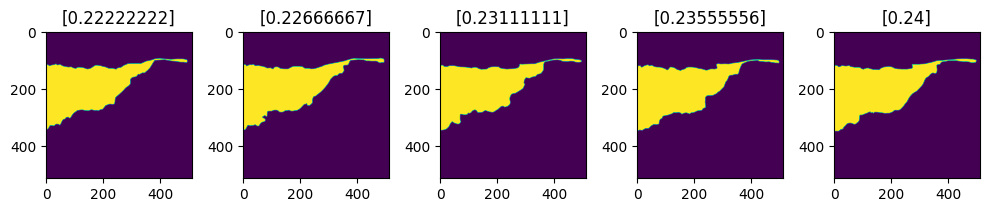

In [27]:
#plot some images and masks
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
n_imgs = 5
for i in range(n_imgs):
    plt.subplot(1, n_imgs, i+1)
    plt.imshow(train_masks[i+50])
    # label in the title
    plt.title(train_labels[i+50])
plt.tight_layout()

### Models

In [35]:
# Instantiate the CVAE model
cvae = CVAE(input_shape=config["data"]["input_size"],
            labels=train_labels, 
            config=config)

DEBUG:root:Building CVAE model using specified hyperparameters.
DEBUG:root:Encoder: Input shape: (None, 512, 512)
DEBUG:root:Encoder: Output shape after conv_block: (None, 256, 256, 32)
DEBUG:root:Encoder: Output shape after Flatten: (None, 2097152)
DEBUG:root:Encoder: Output shape after Dense layer: (None, 64)
DEBUG:root:Decoder: Input shape after Concatenate: (None, 65)
DEBUG:root:Decoder: Output shape after Dense layer: (None, 262144)
DEBUG:root:Decoder: Output shape after Reshape layer: (None, 128, 128, 16)
DEBUG:root:Decoder: Output shape after deconv_block: (None, 256, 256, 64)
DEBUG:root:Decoder: Output shape after deconv_block: (None, 512, 512, 128)
DEBUG:root:Decoder: Output shape after Conv2DTranspose layer: (None, 512, 512, 1)
DEBUG:root:Combined Model: Output shape after decoder: (None, 512, 512)


In [36]:
cvae.compile(optimizer=config["CVAE"]["optimizer"], 
             lr=config["CVAE"]["learning_rate"])

In [37]:
# FALTA AQUI INPUTR DE TRAIN MASKS...

cvae.train(train_data=(train_masks, train_labels),
           epochs=2, 
           batch_size=2,
           validation_data=([test_masks, test_labels], test_masks),
           callbacks=[])


Epoch 1/2


TypeError: in user code:

    File "c:\Users\tiago\miniconda3\envs\cvae\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)

    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__mse_kl_loss() missing 2 required positional arguments: 'z_mean' and 'z_log_var'


In [73]:


# Build CVAE model
cvae_model = cvae.build_cvae()

# Compile CVAE model
cvae.compile_cvae(optimizer='adam')

# Train CVAE model
cvae.train_cvae(train_data=(x_train, y_train), epochs=1, batch_size=32,
                callbacks=[tensorboard_callback])


Config type: <class 'dict'>


In [13]:
config["CVAE"]["latent_dim"]


64